In [2]:
import warnings
import awkward as ak
import numpy as np
import hist as hs
from hist.intervals import ratio_uncertainty

from coffea import processor
from coffea.nanoevents.methods import vector, candidate
from numba import jit

from coffea.nanoevents import BaseSchema
import mplhep as hep
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import date
today = date.today()

plt.style.use(hep.style.CMS)
#plt.style.use('dark_background')

/uscms_data/d3/ahayrape/mamba/envs/anal/lib/python3.9/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'awkward.numba' failed to load due to 'FileNotFoundError([Errno 2] No such file or directory: '/uscms_data/d3/ahayrape/mamba/envs/anal/lib/python3.9/site-packages/numpy-1.23.2.dist-info/METADATA')'.
  numba.core.entrypoints.init_all()


In [5]:
class LLP_ntuple_processor(processor.ProcessorABC):
    
    def delta_cls_gLLP(self, events):
        clusts = ak.zip(
            {
                'pt': ak.zeros_like(events.dtRechitClusterPhi),
                'phi': events.dtRechitClusterPhi,
                'eta': events.dtRechitClusterEta,
                'E': ak.zeros_like(events.dtRechitClusterPhi),
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )
        gLLPs = ak.zip(
            {
                'pt': events.gLLP_pt,
                'phi': events.gLLP_phi,
                'eta': events.gLLP_eta,
                'E': events.gLLP_e,
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )        
        cls_llp_pairs = ak.cartesian({
            "cls": clusts, 
            "llp": gLLPs
        }, nested = True) 
        
        deltaR = (cls_llp_pairs.cls).delta_r(cls_llp_pairs.llp)
        deltaEta = abs(cls_llp_pairs.cls.eta - cls_llp_pairs.llp.eta)
        deltaPhi = np.arctan2(np.sin(cls_llp_pairs.cls.phi - cls_llp_pairs.llp.phi), 
                              np.cos(cls_llp_pairs.cls.phi - cls_llp_pairs.llp.phi))
        
        deltaR, deltaEta, deltaPhi = ak.flatten(deltaR, axis=2), ak.flatten(deltaEta, axis=2), ak.flatten(deltaPhi, axis=2)
        return deltaR, deltaEta, deltaPhi,
    
    def delta_cls_leadmuon(self, events):
        clusts = ak.zip(
            {
                'pt': ak.zeros_like(events.dtRechitClusterPhi),
                'phi': events.dtRechitClusterPhi,
                'eta': events.dtRechitClusterEta,
                'E': ak.zeros_like(events.dtRechitClusterPhi),
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )
        leadMuons = ak.zip(
            {
                'pt': events.leadMuonPt,
                'phi': events.leadMuonPhi,
                'eta': events.leadMuonEta,
                'E': events.leadMuonE,
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          ) 
        cls_muon_pairs = ak.cartesian({
            "cls": clusts, 
            "muon": leadMuons
        }, nested = True)
 
        deltaR = (cls_muon_pairs.cls).delta_r(cls_muon_pairs.muon)
        deltaEta = abs(cls_muon_pairs.cls.eta - cls_muon_pairs.muon.eta)
        deltaPhi = np.arctan2(np.sin(cls_muon_pairs.cls.phi - cls_muon_pairs.muon.phi), 
                              np.cos(cls_muon_pairs.cls.phi - cls_muon_pairs.muon.phi))
        
        deltaR, deltaEta, deltaPhi = ak.flatten(deltaR, axis=2), ak.flatten(deltaEta, axis=2), ak.flatten(deltaPhi, axis=2)
        return deltaR, deltaEta, deltaPhi
        
    
    def process(self, events):
        
        signame = 'Phi'
        
        # >>> output dict init >>>
        dataset = events.metadata['dataset']
        out = {
            dataset: {},
            f'{dataset}_cuts': {},
            f'{dataset}_vars': {},
        }
        # <<< output dict init <<<
        
        out[dataset][f'numEvents_pretrigger'] = len(events)
        
        # >>> some preprocessing >>>
        
        # add a new set of branches that only consists of values pertaining to muons
        muoncut = abs(events.lepPdgId) == 13
        events['muonE'] = events.lepE[muoncut]
        events['muonPt'] = events.lepPt[muoncut]
        events['muonEta'] = events.lepEta[muoncut]
        events['muonPhi'] = events.lepPhi[muoncut]
        events['muonPdgId'] = events.lepPdgId[muoncut]
        events['muonDZ'] = events.lepDZ[muoncut]
        events['muonLooseId'] = events.lepLooseId[muoncut]
        events['muonTightId'] = events.lepTightId[muoncut] 
        if 'mPhi0p3' in dataset:
            events['muonType'] = events.lepMuonType[muoncut]
            events['muonQuality'] = events.lepMuonQuality[muoncut]
            events['muon_passHLTFilter'] = events.lepMuon_passHLTFilter[muoncut]
        events = events[ak.count(events.muonPt, axis=1) > 0] #kill all events with empty muons
        out[dataset][f'numEvents_|muonId| == 13'] = len(events.muonPt)
        
        # cut and mutate events based on this new branch
        def muoncutter(events, muoncut):
            events['muonE'] = events.muonE[muoncut]
            events['muonPt'] = events.muonPt[muoncut]
            events['muonEta'] = events.muonEta[muoncut]
            events['muonPhi'] = events.muonPhi[muoncut]
            events['muonPdgId'] = events.muonPdgId[muoncut]
            events['muonDZ'] = events.muonDZ[muoncut]
            events['muonLooseId'] = events.muonLooseId[muoncut]
            events['muonTightId'] = events.muonTightId[muoncut]
            if 'mPhi0p3' in dataset:
                events['muonType'] = events.muonType[muoncut]
                events['muonQuality'] = events.muonQuality[muoncut]
                events['muon_passHLTFilter'] = events.muon_passHLTFilter[muoncut]
            events = events[ak.count(events.muonPt, axis=1) > 0] #kill all events with empty muons
            return events

        if 'mPhi0p3' in dataset:
            events = muoncutter(events, ak.any(events.muon_passHLTFilter[:,:,range(60,68)], axis=2))
            out[dataset][f'numEvents_muonHLTReq'] = len(events.muonPt)
            
        events = muoncutter(events, abs(events.muonEta) < 1.5)
        out[dataset][f'numEvents_|muonEta| < 1.5'] = len(events.muonPt)
        events = muoncutter(events, events.muonPt > 7)
        out[dataset][f'numEvents_muonPt > 7'] = len(events.muonPt)
        
        if 'mPhi0p3' in dataset:       
            events = muoncutter(events, events.muonQuality >= 2**25)
            out[dataset][f'numEvents_soft_muon_ID'] = len(events.muonPt) 
            
        # finally keep only the leading muon
        leadcut = (ak.max(events.muonPt, axis=1, mask_identity=True) == events.muonPt)
        events['leadMuonE'] = events.muonE[leadcut][:,0]
        events['leadMuonPt'] = events.muonPt[leadcut][:,0]
        events['leadMuonEta'] = events.muonEta[leadcut][:,0]
        events['leadMuonPhi'] = events.muonPhi[leadcut][:,0]
        events['leadMuonPdgId'] = events.muonPdgId[leadcut][:,0]
        events['leadMuonDZ'] = events.muonDZ[leadcut][:,0]
        events['leadMuonLooseId'] = events.muonLooseId[leadcut][:,0]
        events['leadMuonTightId'] = events.muonTightId[leadcut][:,0]
        if 'mPhi0p3' in dataset:
            events['leadMuonType'] = events.muonType[leadcut][:,0]
            events['leadMuonQuality'] = events.muonQuality[leadcut][:,0]
            events['leadMuon_passHLTFilter'] = events.muon_passHLTFilter[leadcut][:,0]   
        
        # add branches pertaining to deltaR between either leading muon and cluster, or llp and cluster
        # <<< some preprocessing <<<
        
        if dataset != "background":
            cls_llp_deltaR, cls_llp_deltaEta, cls_llp_deltaPhi = self.delta_cls_gLLP(events)
            events['dtRechitCluster_llp_deltaR'] = cls_llp_deltaR
            events['dtRechitCluster_llp_deltaEta'] = cls_llp_deltaEta
            events['dtRechitCluster_llp_deltaPhi'] = cls_llp_deltaPhi

        cls_leadmuon_deltaR, cls_leadmuon_deltaEta, cls_leadmuon_deltaPhi = self.delta_cls_leadmuon(events)
        events['dtRechitCluster_leadmuon_deltaR'] = cls_leadmuon_deltaR
        events['dtRechitCluster_leadmuon_deltaEta'] = cls_leadmuon_deltaEta
        events['dtRechitCluster_leadmuon_deltaPhi'] = cls_leadmuon_deltaPhi

        # >>> cut definitions >>>

        HLT_MU_IP_sel = range(1157,1197)

        events = events[ak.any(events.HLTDecision[:,HLT_MU_IP_sel], axis=1)]
        dummy = ak.values_astype(ak.ones_like(events.nDtRechitClusters), 'bool') #dummy truth vector of same shape as csc variables
        dtCuts = {
            'no_cut': dummy, 
            'llp_acc': (events.gLLP_dt == 1), # if signame in dataset else dummy,
            'num Cluster > 0': ((events.nDtRechitClusters > 0) & (events.dtRechitClusterSize >= 50)),
            'dR_gllp_cls < .4': (events.dtRechitCluster_llp_deltaR < 0.4) if signame in dataset else dummy,
            'dR_lmuon_cls > .8': (events.dtRechitCluster_leadmuon_deltaR > .8),
            'station_veto': (events.nDtStations25 < 3),
            'wheel_veto': (events.nDtWheels25 < 3),
            'muon_veto_pt < 20': (events.dtRechitClusterMuonVetoPt < 20),
            'mb1_veto': (events.dtRechitCluster_match_MB1hits_0p5 <= 1),
            'rpc_matching': (events.dtRechitCluster_match_RPChits_dPhi0p5 > 0),
            'mb1_adjacent': ((events.dtRechitCluster_match_MB1hits_cosmics_plus <= 8) & (events.dtRechitCluster_match_MB1hits_cosmics_plus <= 8)),
            'cluster_size_100': (events.dtRechitClusterSize > 100)
        }
        # <<< cut definitions <<<
        
        # >>> variables to be plotted >>>                
        __ = lambda x: x
        bins = 30
        
        #must be same shape as any dt variable
        dtVars = {
            'dtRechitClusterSize': [bins,    50, 300, __, ],
            'dtRechitClusterEta':  [bins,    0,   3, abs,],
            'dtRechitClusterPhi':  [bins,    0,   3, abs,],
            'gLLP_dt'  :  [bins,    0,   3, __,],
            'gLLP_ctau':  [bins,    0,   1000, __,],
        }
        
        if signame in dataset:
            dtVars['dtRechitCluster_llp_deltaR']   = [bins, 0, 5, __,]
            dtVars['dtRechitCluster_llp_deltaEta'] = [bins, 0, 5, abs,]
            dtVars['dtRechitCluster_llp_deltaPhi'] = [bins, 0, 5, __,]

        dtVars['dtRechitCluster_leadmuon_deltaR']   = [bins, 0, 5, __,]
        dtVars['dtRechitCluster_leadmuon_deltaEta'] = [bins, 0, 5, abs,]
        dtVars['dtRechitCluster_leadmuon_deltaPhi'] = [bins, 0, 5, __,]
        
        #must be flat variables of length nEvents
        eventVars = {
            # 'metEENoise': [bins,   0, 100, __, ],
        }
        
        if signame in dataset:        
            eventVars['gLLP_decay_vertex_z'] = [2*bins,   0, 1200, abs, ]
            eventVars['gLLP_e'] = [bins,   0, 100, __, ]
            
        Vars = dtVars | eventVars
        # <<< variables to be plotted <<<
        
        # >>> create hists >>> 
        bigCut = dtCuts[list(dtCuts.keys())[0]] #sets first cut
        for cut in dtCuts:
            out[f'{dataset}_cuts'][cut] = 1       
            bigCut = bigCut & dtCuts[cut]
            
            if bigCut.layout.minmax_depth == (2,2):
                temp = ak.any(bigCut, axis=1)
            elif bigCut.layout.minmax_depth == (1,1):
                temp = bigCut
            
            out[dataset][f'numEvents_{cut}'] = sum(temp)
            
            for var in Vars:
                v = Vars[var]
                if bigCut.layout.minmax_depth == (2,2) and events[var].layout.minmax_depth == (1,1):
                    temp2 = ak.any(bigCut, axis=1)
                else:
                    temp2 = bigCut
                data = events[var][temp2]
                data = ak.flatten(data, axis=None)
                data = v[3](data)
                key = f'{var} with {cut}'
                out[f'{dataset}_vars'][key] = data.to_list()
                if 'gLLP_e' in var:
                    out[dataset][key] = hs.Hist.new.Reg(v[0], v[1]+1, v[2], name=var, label=var, transform=hs.axis.transform.log).Double()
                else:
                    out[dataset][key] = hs.Hist.new.Reg(v[0], v[1], v[2], name=var, label=var).Double()
                out[dataset][key].fill(data) 
        # <<< create hists <<<

        return out
    
    def postprocess(self, accumulator):
        return accumulator
    

In [17]:
import warnings

warnings.filterwarnings("ignore")

prefix = 'root://cmsxrootd.fnal.gov//store/user/christiw/displacedJetMuonAnalyzer/bparking/V1p19/MC_Fall18/v1/v9/normalized/'

fileset = {
            'PhiToPi0Pi0_mPhi1p0_ctau1000':
                ['./rootfiles/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000_1pb_weighted.root'],

            'PhiToPi0Pi0_mPhi0p3_ctau1000':
                [prefix + 'BToKPhi_MuonGenFilter_PhiToPi0Pi0_mPhi0p3_ctau1000_1pb_weighted.root'],

            'PhiToPi0Pi0_mPhi0p3_ctau300':
                 [prefix + 'BToKPhi_MuonGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_1pb_weighted.root'],

            'PhiToPiPlusPiMinus_mPhi0p3_ctau1000':
                [prefix + 'BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau1000_1pb_weighted.root'],

            'PhiToPiPlusPiMinus_mPhi0p3_ctau300':
                [prefix + 'BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau300_1pb_weighted.root'],
            }

out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=LLP_ntuple_processor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 16},
    # executor_args={"schema": BaseSchema, "workers": 1},
    #maxchunks = 1,
    # chunksize=1000000,
)

Output()

In [37]:
datasets = [
    'PhiToPi0Pi0_mPhi1p0_ctau1000',
    'PhiToPi0Pi0_mPhi0p3_ctau1000',
    'PhiToPi0Pi0_mPhi0p3_ctau300',
    'PhiToPiPlusPiMinus_mPhi0p3_ctau1000',
    'PhiToPiPlusPiMinus_mPhi0p3_ctau300',
]
signame = "Phi"
for dataset in datasets:
    print(dataset)
    if signame in dataset:
        if 'ctau1000' in dataset:
            oldctau = 100
        if 'ctau300' in dataset:
            oldctau = 30

        N_events_acceptance = out[dataset]["numEvents_llp_acc"]
        N_events_no_cut = out[dataset]["numEvents_no_cut"]

        # _________________ Efficiency calculation _________________
        eff_sig_old = N_events_acceptance / N_events_no_cut

        def weight_calc(llp_ct, new_ctau, old_ctau):
            return (old_ctau/new_ctau) * np.exp(llp_ct*(1/old_ctau - 1/new_ctau))

        ctau_list = np.logspace(-.3, 4, 50)
        eff = np.zeros_like(ctau_list)
        gLLP_ctau = np.array(out[f"{dataset}_vars"]["gLLP_ctau with llp_acc"]) #cuts gLLP_ctau

        for i, ct in enumerate(ctau_list):
            weight_ctau = weight_calc(gLLP_ctau, ct, oldctau) # convert everything to cm
            eff_sig_new = np.sum(weight_ctau)/out[dataset]["numEvents_no_cut"]
            eff[i] = eff_sig_new

        out[dataset]['ctau_list'] = ctau_list
        out[dataset]['eff'] = eff

        # _________________ Branching ratio estimation _________________
        cutevents = out[dataset]["numEvents_no_cut"]
        n_events_inverse = 1/cutevents
        print(N_events_acceptance*n_events_inverse)

        def weight_calc(llp_ct, new_ctau, old_ctau):
            return (old_ctau/new_ctau) * np.exp(llp_ct*(1/old_ctau - 1/new_ctau))

        br = np.zeros_like(ctau_list)

        gLLP_ctau = np.array(out[f"{dataset}_vars"]["gLLP_ctau with llp_acc"]) #cuts gLLP_ctau

        nb = 55
        frac_of_B = .02
        BR_old = 2*np.sqrt(nb/frac_of_B)/(5e9*N_events_acceptance*n_events_inverse)

        for i, ct in enumerate(ctau_list):
            weight_ctau = weight_calc(gLLP_ctau, ct, oldctau) # convert everything to cm
            BR_new = 2*np.sqrt(nb/frac_of_B)/(5e9*sum(weight_ctau)*n_events_inverse)
            br[i] = BR_new

        out[dataset]['br'] = br
        # <<< eff and br calculation <<<


PhiToPi0Pi0_mPhi1p0_ctau1000
0.17201505401057227
PhiToPi0Pi0_mPhi0p3_ctau1000
0.1342574052783196
PhiToPi0Pi0_mPhi0p3_ctau300
0.1723282089275792
PhiToPiPlusPiMinus_mPhi0p3_ctau1000
0.1342017570433202
PhiToPiPlusPiMinus_mPhi0p3_ctau300
0.17453608763067074


In [34]:
datasets = list(fileset.keys())
sigcuts = list(out[f'{list(fileset.keys())[0]}_cuts'].keys())
# bkguts = list(out['backgroundNew_cuts'].keys())

sigvars = list(out[f'{list(fileset.keys())[0]}_vars'].keys())
# bkgvars = list(out['backgroundNew_vars'].keys())

φ→π0π0; ctau = 100cm; m = 1.0GeV
φ→π+π-; ctau = 100cm; m = 0.3GeV
φ→π+π-; ctau = 30cm; m = 0.3GeV
φ→π0π0; ctau = 30cm; m = 0.3GeV
φ→π0π0; ctau = 100cm; m = 0.3GeV


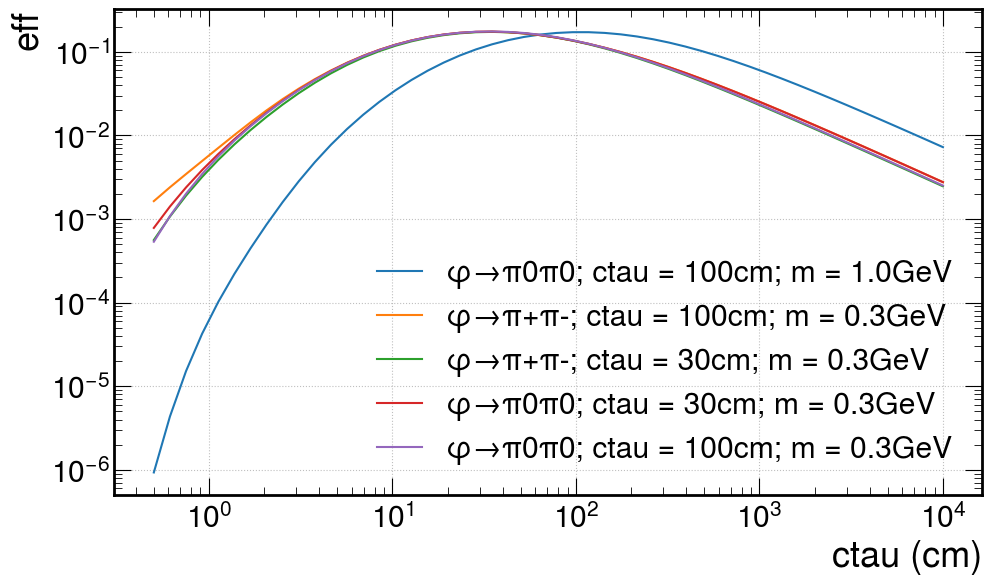

In [35]:
import matplotlib.pyplot as plt
import gc

labels = {
    "PhiToPi0Pi0_mPhi1p0_ctau1000":        "φ→π0π0; ctau = 100cm; m = 1.0GeV",
    "PhiToPi0Pi0_mPhi0p3_ctau1000":        "φ→π+π-; ctau = 100cm; m = 0.3GeV",
    "PhiToPi0Pi0_mPhi0p3_ctau300":         "φ→π+π-; ctau = 30cm; m = 0.3GeV",
    "PhiToPiPlusPiMinus_mPhi0p3_ctau300":  "φ→π0π0; ctau = 100cm; m = 0.3GeV",
    "PhiToPiPlusPiMinus_mPhi0p3_ctau1000": "φ→π0π0; ctau = 30cm; m = 0.3GeV"
}

a = 0.7
fig, ax = plt.subplots(figsize = (a*16,a*9))
for sets in datasets:
    print(labels[sets])
    ax.plot(out[sets]['ctau_list'], out[sets]['eff'], label=labels[sets])

plt.xscale("log")
plt.yscale("log")
plt.xlabel("ctau (cm)")
plt.ylabel("eff")
plt.legend()
plt.grid()
plt.show()

φ→π0π0; ctau = 100cm; m = 1.0GeV
φ→π+π-; ctau = 100cm; m = 0.3GeV
φ→π+π-; ctau = 30cm; m = 0.3GeV
φ→π0π0; ctau = 30cm; m = 0.3GeV
φ→π0π0; ctau = 100cm; m = 0.3GeV


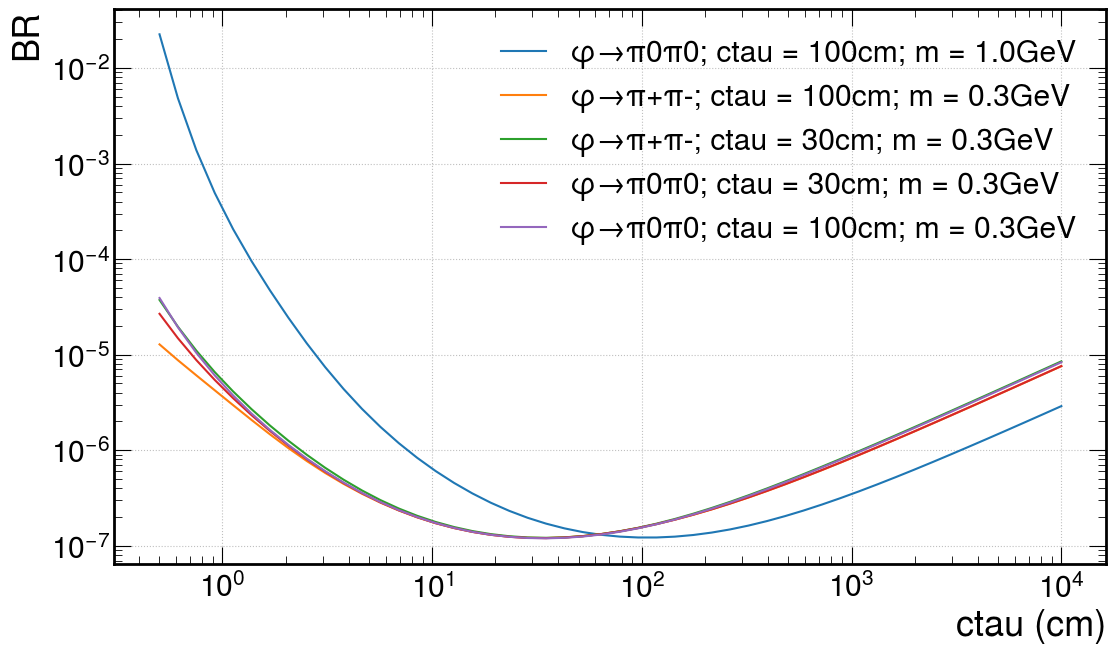

In [36]:
import matplotlib.pyplot as plt
import gc

labels = {
    "PhiToPi0Pi0_mPhi1p0_ctau1000":        "φ→π0π0; ctau = 100cm; m = 1.0GeV",
    "PhiToPi0Pi0_mPhi0p3_ctau1000":        "φ→π+π-; ctau = 100cm; m = 0.3GeV",
    "PhiToPi0Pi0_mPhi0p3_ctau300":         "φ→π+π-; ctau = 30cm; m = 0.3GeV",
    "PhiToPiPlusPiMinus_mPhi0p3_ctau300":  "φ→π0π0; ctau = 100cm; m = 0.3GeV",
    "PhiToPiPlusPiMinus_mPhi0p3_ctau1000": "φ→π0π0; ctau = 30cm; m = 0.3GeV"
}

a = 0.8
fig, ax = plt.subplots(figsize = (a*16,a*9))
for sets in datasets:
    print(labels[sets])
    ax.plot(out[sets]['ctau_list'], out[sets]['br'], label=labels[sets])

plt.xscale("log")
plt.yscale("log")
plt.xlabel("ctau (cm)")
plt.ylabel("BR")
plt.legend()
plt.grid()
plt.show()

In [17]:
datasets = list(fileset.keys())

for dataset in datasets:
    print(dataset)
    for key in out[dataset]:
        if key.startswith('numEvents_'):# and ('NStation10' not in key):
            print(f"{key[10:]}, {out[dataset][key]}")
            #print(f"{out[dataset][key]}")
    print()

PhiToPi0Pi0_mPhi1p0_ctau1000
pretrigger, 823789
|muonId| == 13, 812236
|muonEta| < 1.5, 551367
muonPt > 7, 198125
no_cut, 198125
llp_acc, 39745
num Cluster > 0, 5501
dR_gllp_cls < .4, 3967
dR_lmuon_cls > .8, 1463
station_veto, 1400
wheel_veto, 1323
muon_veto_pt < 20, 1274
mb1_veto, 367
rpc_matching, 362
mb1_adjacent, 353
cluster_size_100, 73

PhiToPi0Pi0_mPhi0p3_ctau1000
pretrigger, 927214
|muonId| == 13, 914144
muonHLTReq, 82739
|muonEta| < 1.5, 79621
muonPt > 7, 78978
soft_muon_ID, 77411
no_cut, 77411
llp_acc, 10393
num Cluster > 0, 1282
dR_gllp_cls < .4, 626
dR_lmuon_cls > .8, 525
station_veto, 515
wheel_veto, 503
muon_veto_pt < 20, 459
mb1_veto, 148
rpc_matching, 145
mb1_adjacent, 142
cluster_size_100, 31

PhiToPi0Pi0_mPhi0p3_ctau300
pretrigger, 653247
|muonId| == 13, 644069
muonHLTReq, 57730
|muonEta| < 1.5, 55564
muonPt > 7, 55087
soft_muon_ID, 53990
no_cut, 53990
llp_acc, 9304
num Cluster > 0, 1288
dR_gllp_cls < .4, 740
dR_lmuon_cls > .8, 614
station_veto, 600
wheel_veto, 565
mu

In [6]:
import mplhep
from hist.intervals import ratio_uncertainty
import matplotlib.patches as patches

plt.style.use(mplhep.style.CMS)


def ratio(num, den, rax):

    rax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view(), "efficiency"),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    return rax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(400,1075)
    (xmin,xmax) = ax.get_xlim()
    f = 16
    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1050, 0),50, 2,color='grey',alpha=0.3)

    ax.text(570, y_max*1.02, 'ME1/1', fontsize=f)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=f)
    ax.text(800, y_max*1.02, 'ME2', fontsize=f)
    ax.text(920, y_max*1.02, 'ME3', fontsize=f)
    ax.text(1015, y_max*1.02,'ME4', fontsize=f)
    ax.text(xmin+5 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-20,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax


In [13]:
out[key]['gLLP_decay_vertex_z_matched with no_cut'].sum()/out[key]['gLLP_decay_vertex_z with no_cut'].sum()

0.08146477378267215

/tmp/ipykernel_10335/458755856.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_10335/458755856.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_10335/458755856.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_10335/458755856.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


φ→π0π0; ctau = 1000mm; m = 0.3GeV; 
 0.07208326860338667
φ→π0π0; ctau = 300mm; m = 0.3GeV; 
 0.0926381373995737
φ→π+π-; ctau = 300mm; m = 0.3GeV; 
 0.1323070058009817
φ→π+π-; ctau = 1000mm; m = 0.3GeV; 
 0.08146477378267215


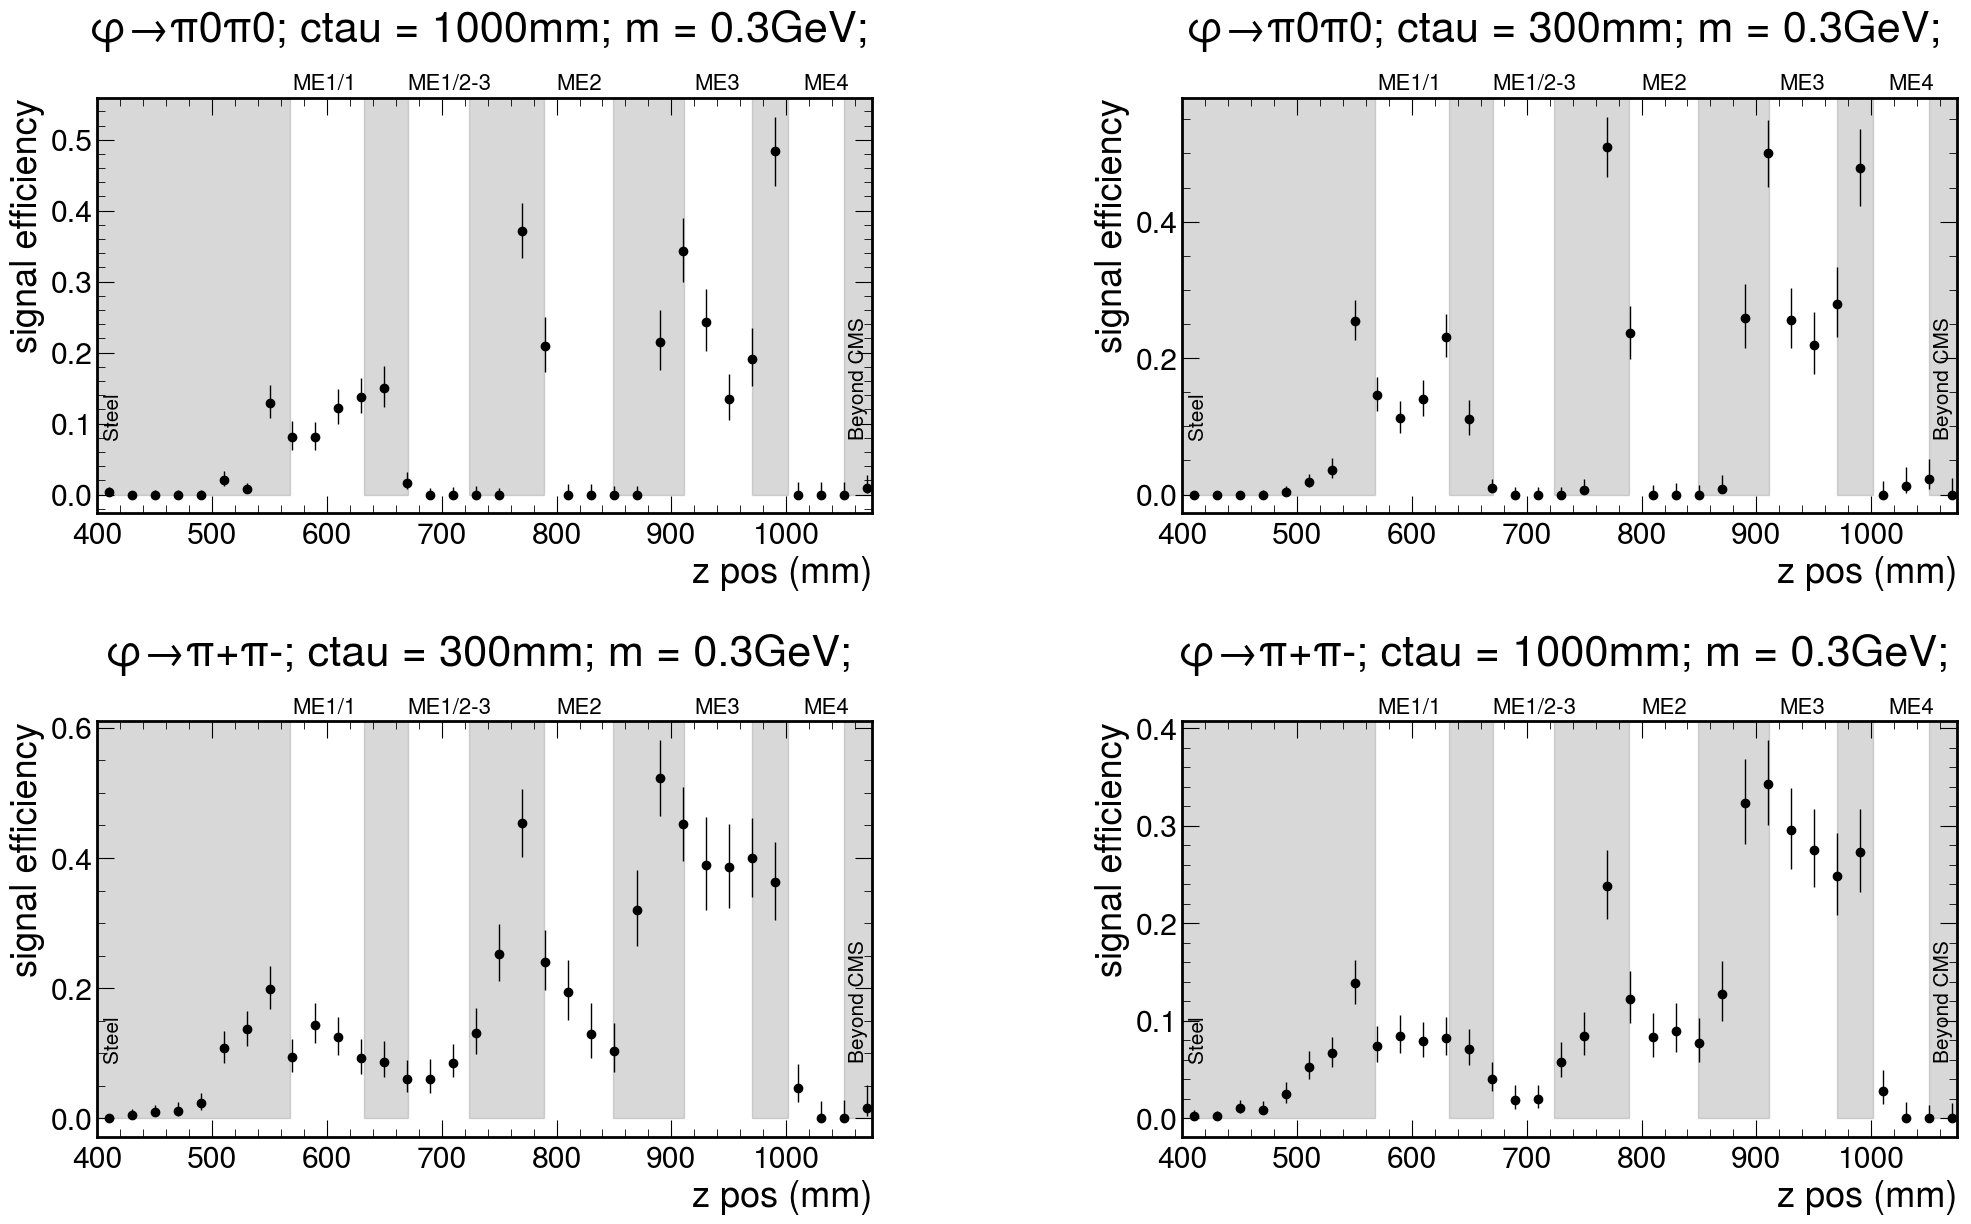

In [15]:
a = 1.5
fig, axes = plt.subplots(2,2, figsize = (a*16,a*9))

for ax, key in zip(axes.flatten(), datasets):
    ratio(out[key]['gLLP_decay_vertex_z_matched with no_cut'], out[key]['gLLP_decay_vertex_z with no_cut'], ax)
    drawCSCz(ax)
    ax.set_xlabel("z pos (mm)")
    ax.set_ylabel("signal efficiency")
    s = ''
    if 'PiPlusPiMinus' in key:
        s+='φ→π+π-; '
    if 'Pi0Pi0' in key:
        s+='φ→π0π0; '

    if 'ctau1000' in key:
        s+='ctau = 1000mm; '
    if 'ctau300' in key:
        s+='ctau = 300mm; '
        
    if '0p3' in key:
        s+='m = 0.3GeV; \n'
    if '1p0' in key:
        s+='m = 1.0GeV; \n'
        
    ax.set_title(s)
    
    print(s, out[key]['gLLP_decay_vertex_z_matched with no_cut'].sum()/out[key]['gLLP_decay_vertex_z with no_cut'].sum())
        
fig.subplots_adjust(hspace=.5, wspace=.4)
        
plt.show()

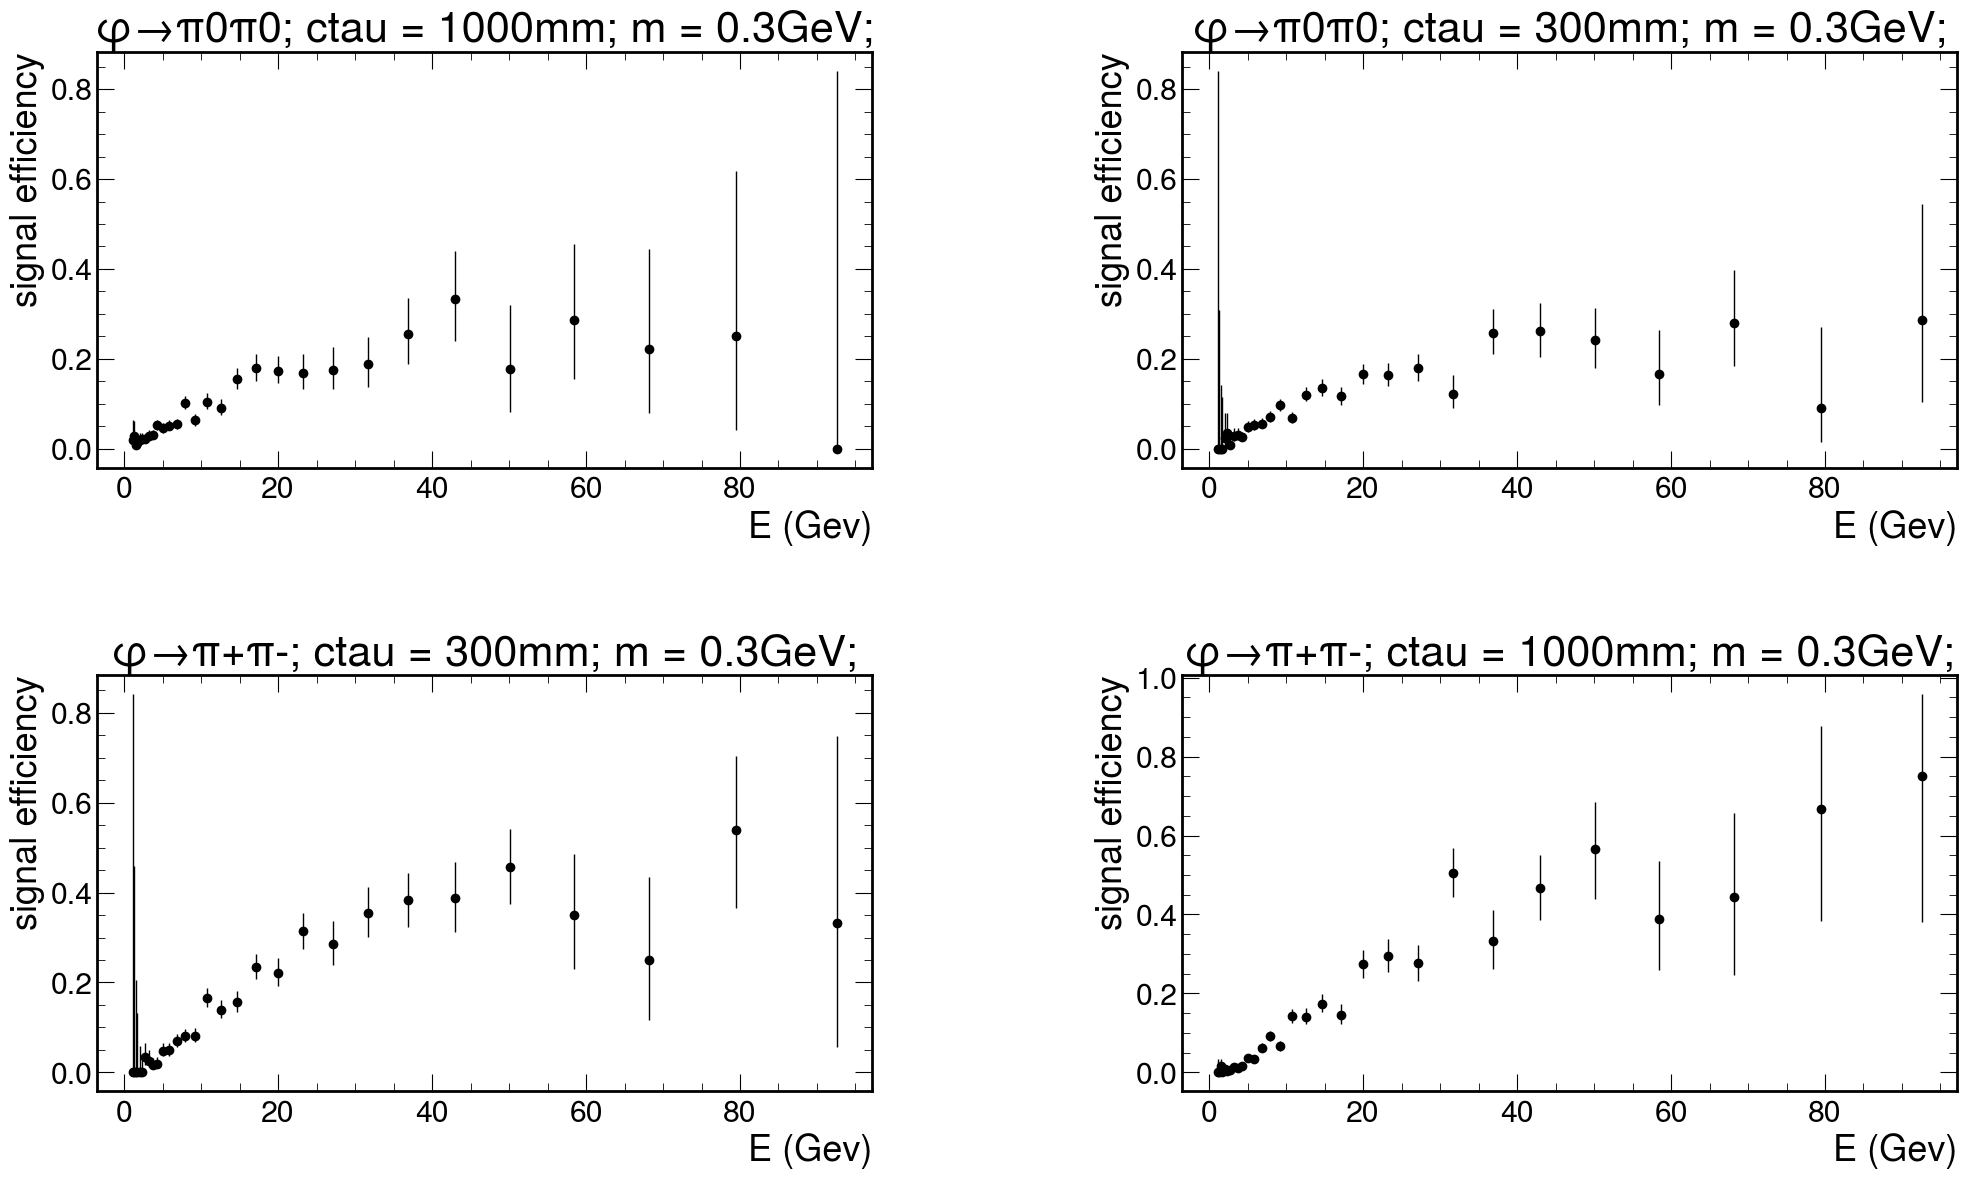

In [9]:
a = 1.5
fig, axes = plt.subplots(2,2, figsize = (a*16,a*9))

for ax, key in zip(axes.flatten(), datasets):
    ratio(out[key]['gLLP_e_matched with no_cut'], out[key]['gLLP_e with no_cut'], ax)
    ax.set_xlabel("E (Gev)")
    ax.set_ylabel("signal efficiency")
    s = ''
    if 'PiPlusPiMinus' in key:
        s+='φ→π+π-; '
    if 'Pi0Pi0' in key:
        s+='φ→π0π0; '

    if 'ctau1000' in key:
        s+='ctau = 1000mm; '
    if 'ctau300' in key:
        s+='ctau = 300mm; '
        
    if '0p3' in key:
        s+='m = 0.3GeV;'
    if '1p0' in key:
        s+='m = 1.0GeV;'
        
    ax.set_title(s)
        
fig.subplots_adjust(hspace=.5, wspace=.4)
        
plt.show()

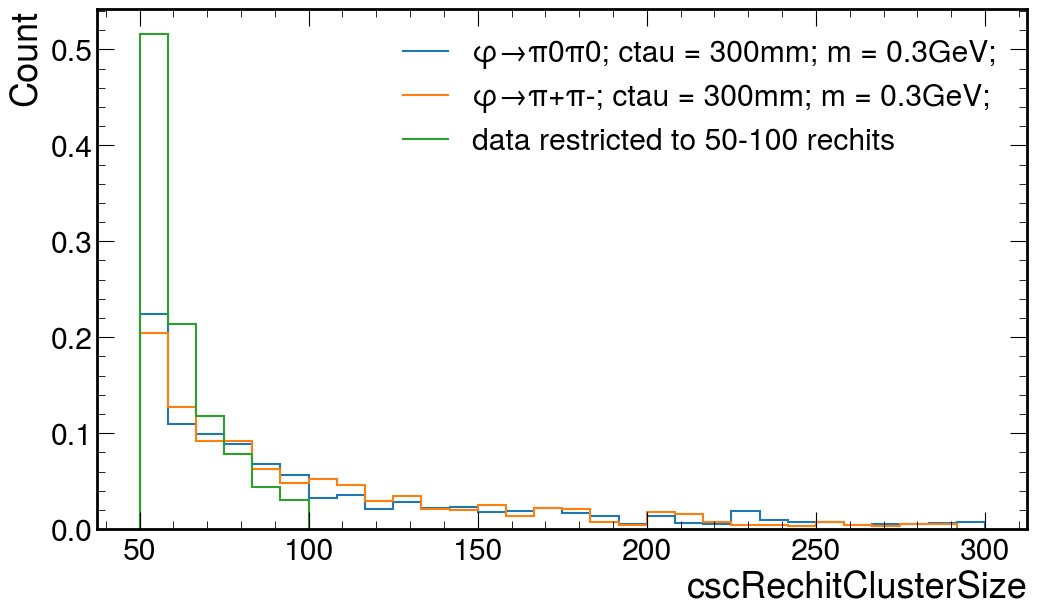

In [22]:
a = .75
fig, ax = plt.subplots(figsize = (a*16,a*9))

for key in [datasets[i] for i in [1,2,4]]:
    
    s = ''
    if 'PiPlusPiMinus' in key:
        s+='φ→π+π-; '
    if 'Pi0Pi0' in key:
        s+='φ→π0π0; '

    if 'ctau1000' in key:
        s+='ctau = 1000mm; '
    if 'ctau300' in key:
        s+='ctau = 300mm; '

    if '0p3' in key:
        s+='m = 0.3GeV;'
    if '1p0' in key:
        s+='m = 1.0GeV;'

    if 'background' in key:
        s+='data restricted to 50-100 rechits'
        temp = out[key][f'cscRechitClusterSize with in_csc'][:100j]/out[key][f'cscRechitClusterSize with in_csc'].sum()
    else:
        temp = out[key][f'cscRechitClusterSize with in_csc']/out[key][f'cscRechitClusterSize with in_csc'].sum()
    
    hep.histplot(temp, label = s, ax=ax)

plt.ylabel('Count')        
plt.legend()
plt.show()

In [24]:
datasets

['PhiToPi0Pi0_mPhi0p3_ctau1000',
 'PhiToPi0Pi0_mPhi0p3_ctau300',
 'PhiToPiPlusPiMinus_mPhi0p3_ctau300',
 'PhiToPiPlusPiMinus_mPhi0p3_ctau1000',
 'backgroundNew']

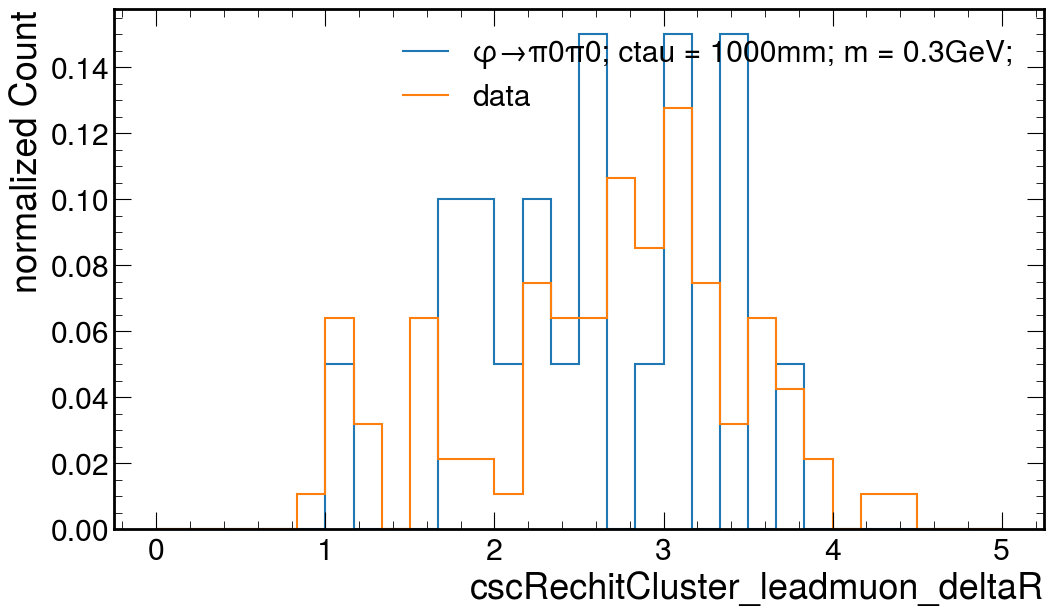

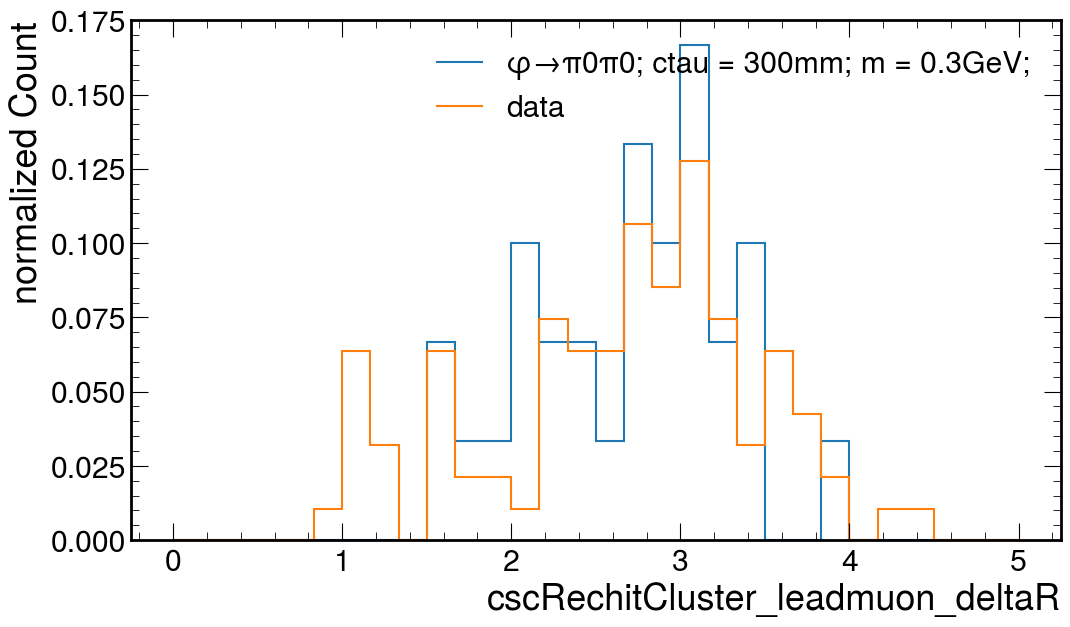

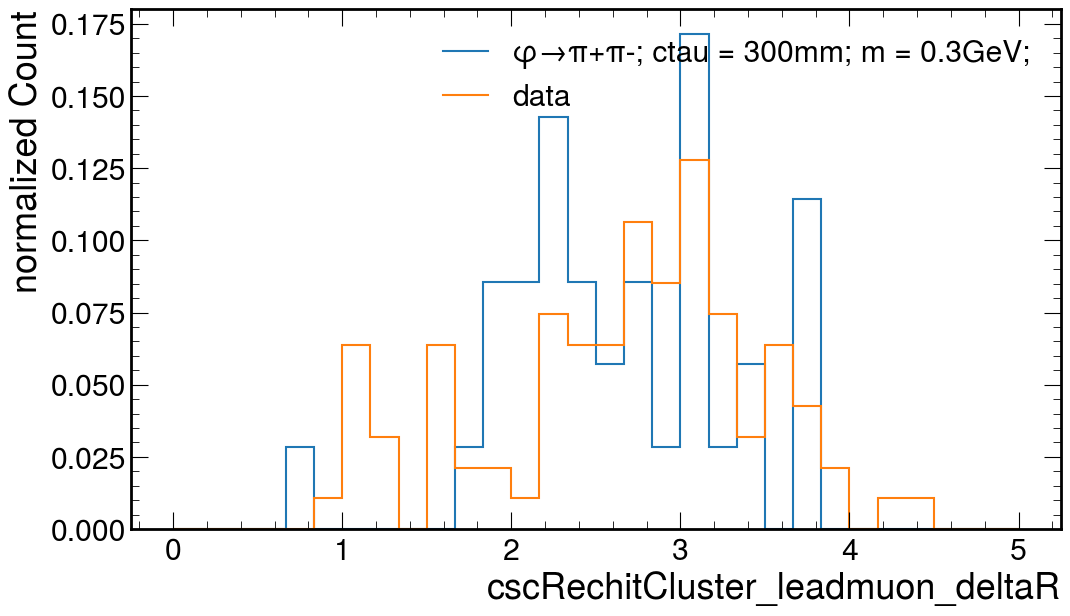

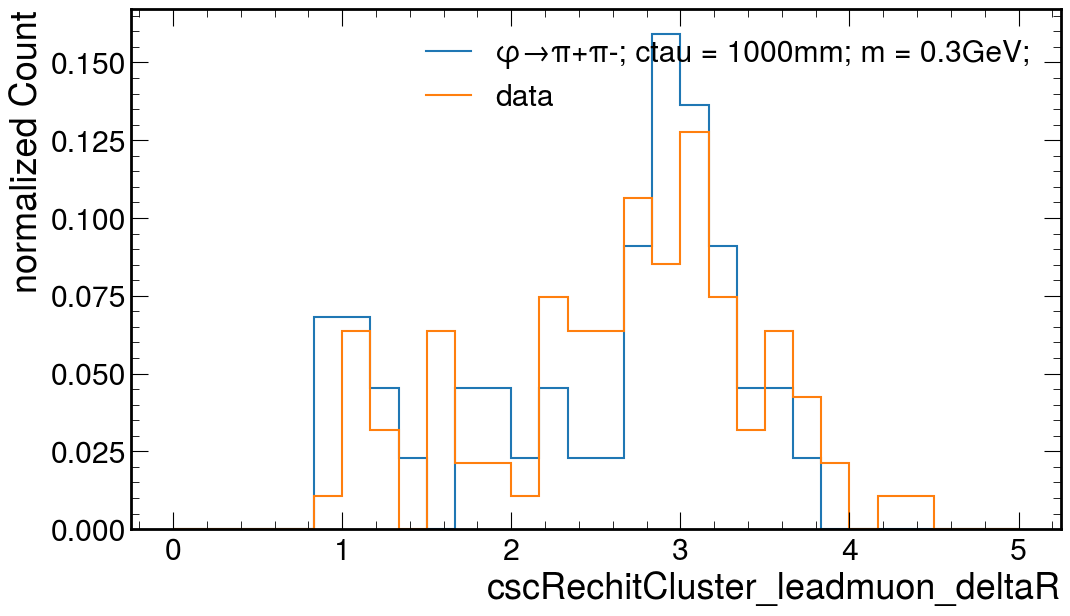

In [10]:
a = .75
for j in range(4):
    fig, ax = plt.subplots(figsize = (a*16,a*9))

    for key in [datasets[i] for i in [j,-1]]:

        s = ''
        if 'PiPlusPiMinus' in key:
            s+='φ→π+π-; '
        if 'Pi0Pi0' in key:
            s+='φ→π0π0; '

        if 'ctau1000' in key:
            s+='ctau = 1000mm; '
        if 'ctau300' in key:
            s+='ctau = 300mm; '

        if '0p3' in key:
            s+='m = 0.3GeV;'
        if '1p0' in key:
            s+='m = 1.0GeV;'

        if 'background' in key:
            s+='data'

        temp = out[key][f'cscRechitCluster_leadmuon_deltaR with cut_based_ID']/out[key][f'cscRechitCluster_leadmuon_deltaR with cut_based_ID'].sum()

        hep.histplot(temp, label = s, ax=ax)

    plt.ylabel('normalized Count')        
    plt.legend()
    plt.show()

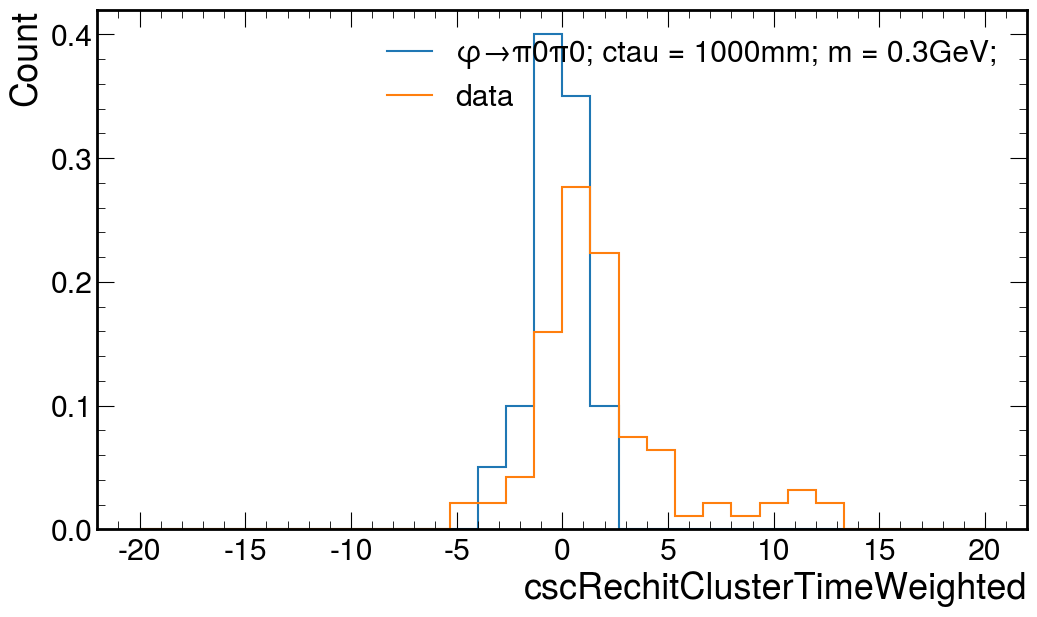

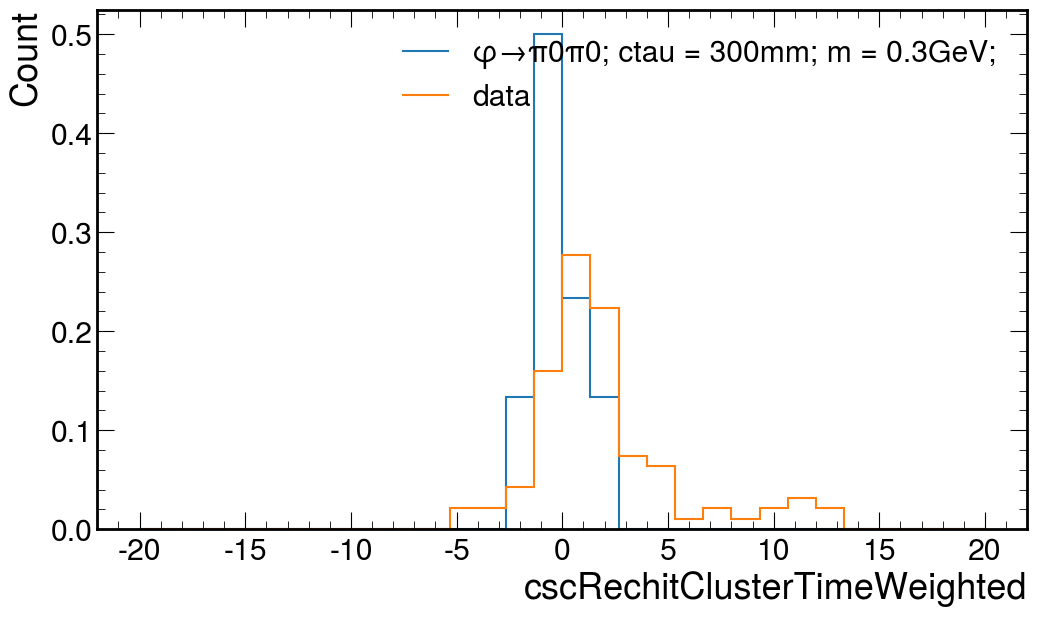

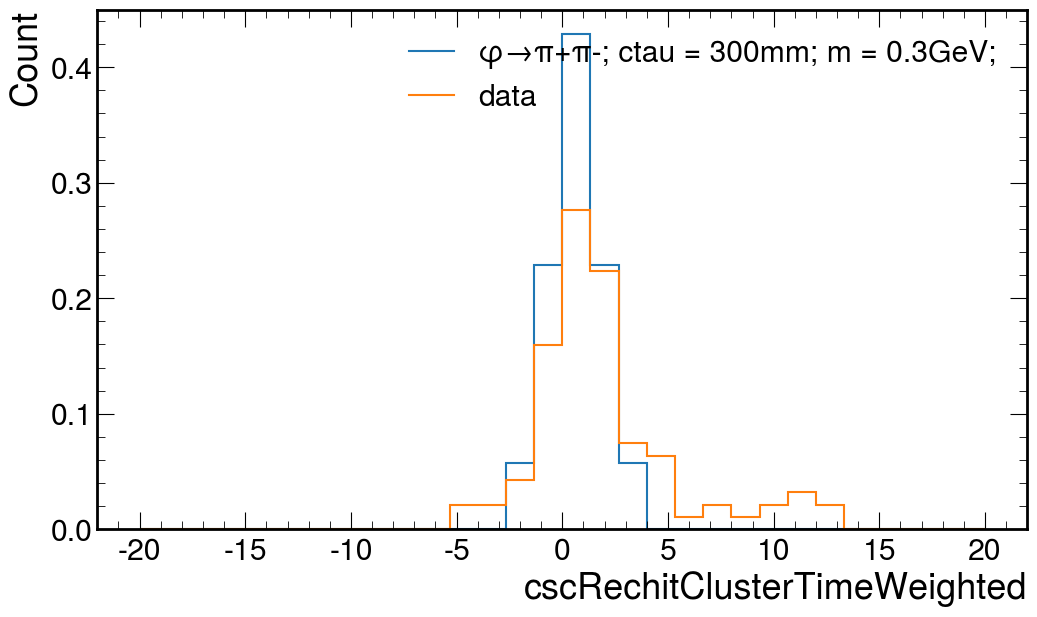

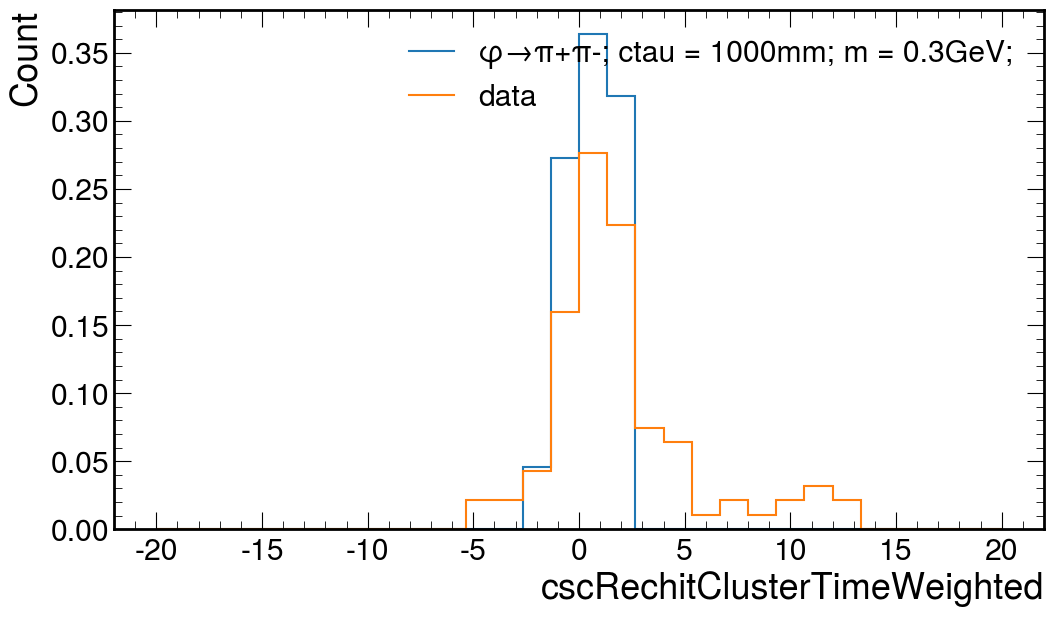

In [14]:
a = .75
for j in range(4):
    fig, ax = plt.subplots(figsize = (a*16,a*9))

    for key in [datasets[i] for i in [j,-1]]:

        s = ''
        if 'PiPlusPiMinus' in key:
            s+='φ→π+π-; '
        if 'Pi0Pi0' in key:
            s+='φ→π0π0; '

        if 'ctau1000' in key:
            s+='ctau = 1000mm; '
        if 'ctau300' in key:
            s+='ctau = 300mm; '

        if '0p3' in key:
            s+='m = 0.3GeV;'
        if '1p0' in key:
            s+='m = 1.0GeV;'

        if 'background' in key:
            s+='data'

        temp = out[key][f'cscRechitClusterTimeWeighted with cut_based_ID']/out[key][f'cscRechitClusterTimeWeighted with cut_based_ID'].sum()

        hep.histplot(temp, label = s, ax=ax)

    plt.ylabel('Count')        
    plt.legend()
    plt.show()

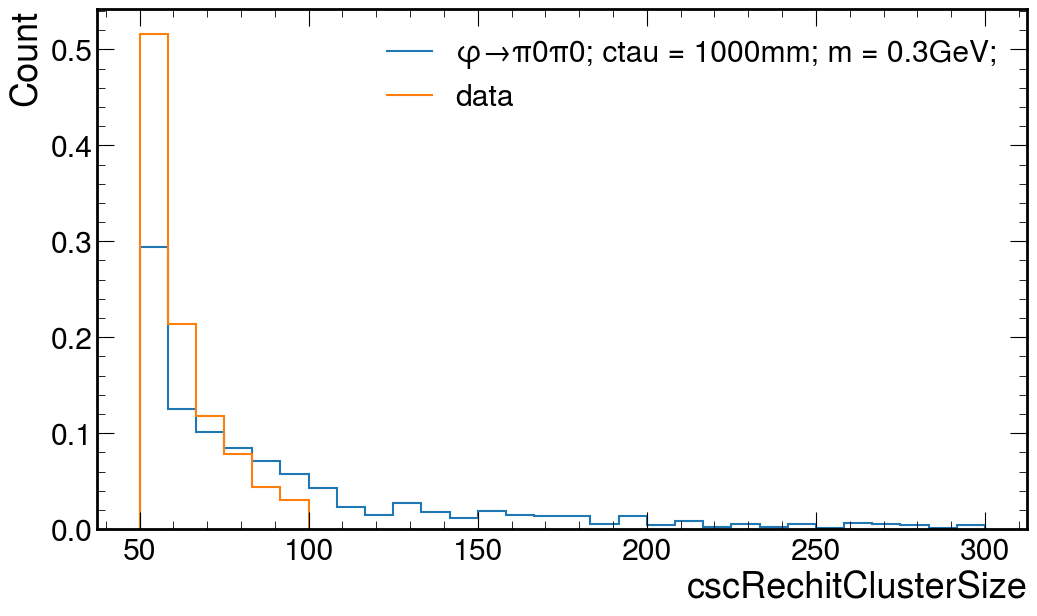

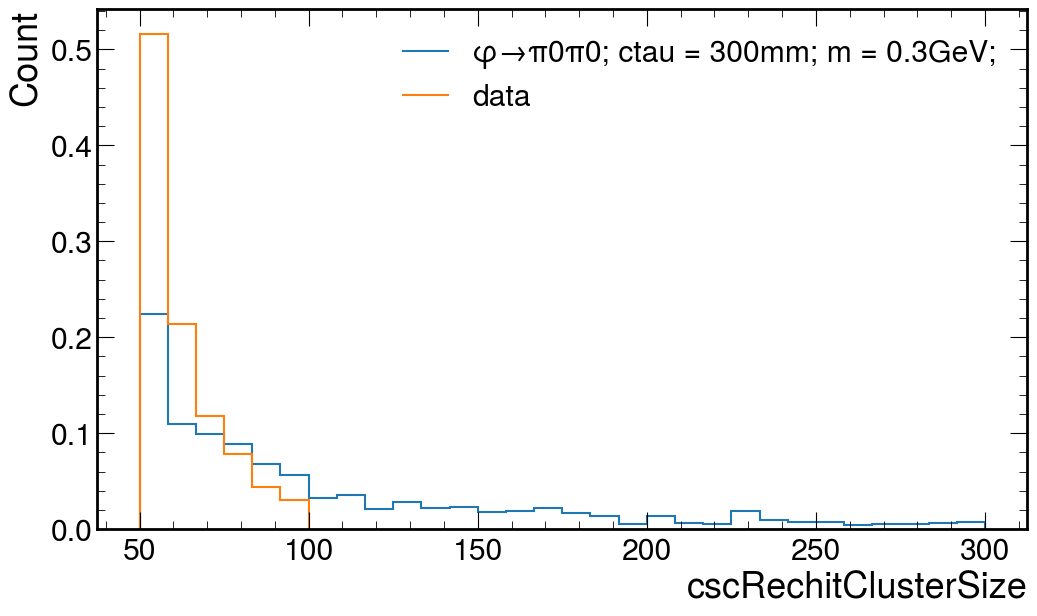

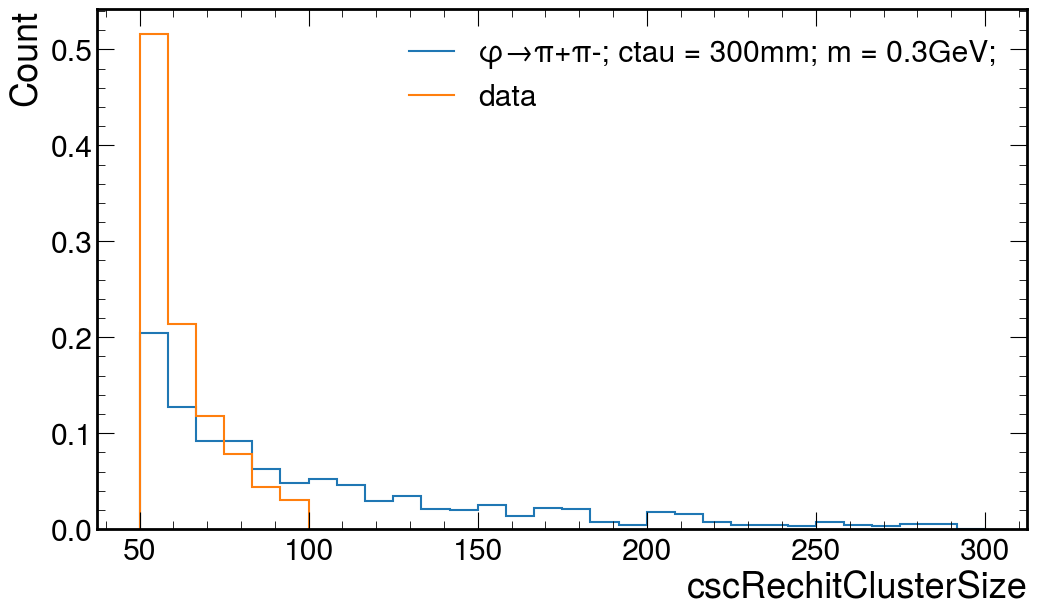

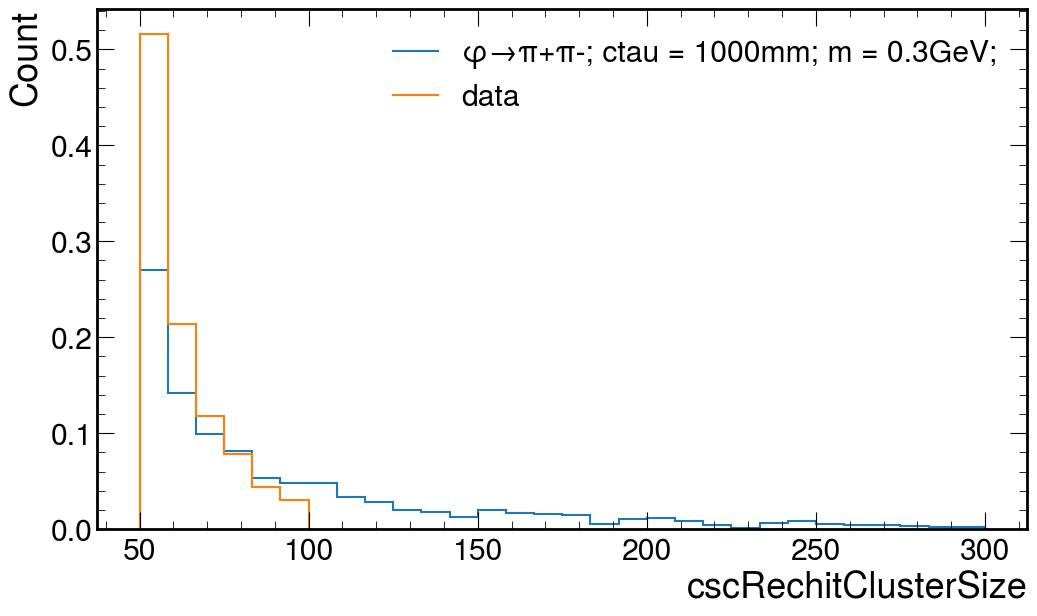

In [20]:
a = .75
for j in range(4):
    fig, ax = plt.subplots(figsize = (a*16,a*9))

    for key in [datasets[i] for i in [j,-1]]:

        s = ''
        if 'PiPlusPiMinus' in key:
            s+='φ→π+π-; '
        if 'Pi0Pi0' in key:
            s+='φ→π0π0; '

        if 'ctau1000' in key:
            s+='ctau = 1000mm; '
        if 'ctau300' in key:
            s+='ctau = 300mm; '

        if '0p3' in key:
            s+='m = 0.3GeV;'
        if '1p0' in key:
            s+='m = 1.0GeV;'

        if 'background' in key:
            s+='data'

        temp = out[key][f'cscRechitClusterSize with in_csc']/out[key][f'cscRechitClusterSize with in_csc'].sum()

        hep.histplot(temp, label = s, ax=ax)

    plt.ylabel('Count')        
    plt.legend()
    plt.show()

In [9]:
arr = np.array([1,2,3,4])
mask = [True, [], True, []]
arr[mask]

/tmp/ipykernel_22275/2541915053.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arr[mask]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed